conda install pytorch==1.4.0 torchvision==0.5.0 -c pytorch
conda install cudatoolkit=11.3
pip install pydicom
pip install omegaconf
pip install timm==0.1.26
pip install ensemble-boxes

conda install pytorch==1.3.0 torchvision==0.4.1 -c pytorch

pip install pylibjpeg 
pip install pylibjpeg-openjpeg

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())


1.12.1.post201
0.13.0a0+8069656
True


In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import os 


In [3]:
import sys
sys.path.insert(0, "/home/ubuntu/ED_project")

import re
import os
from datetime import datetime
import random
import time
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import cv2
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from sklearn.model_selection import StratifiedKFold
import pydicom
import warnings
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import os
from tqdm.notebook import tqdm
import numpy as np


In [5]:
#현재 Not find(15번째 class)를 제외했기 때문에 총 14개의 class가 남아있다
N_CLASSES = 14

#GPU 하나에만 연산 할당
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#데이터 양 조절로 인한 train.csv 파일내 dicom 파일 이름과 실제 dicom 파일간의 불일치 문제 해소
# trian 파일내에 존재하는 dicom 파일로만 이루어진 데이터 프레임을 생성
DIR='/home/ubuntu/ED_project'
y = pd.read_csv(DIR+'/train.csv')

aa = os.listdir(DIR+'/train')
aa = [i.split('.')[0] for i in aa]

d = y[y['image_id'] == aa[0]]

for i in tqdm(aa[1:]):
  h = y[y['image_id'] == i]
  d = pd.concat([h,d])

df = d.reset_index(drop = True)

#StratifiedKFold 기법:
# 불균형한 DataSet을 위한 KFold 방법
# 각 클래스의 특정 퍼센트를 유지한 체 나눈다
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
df_folds = df[['image_id']].copy()

df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'object_count'] = df.groupby('image_id')['class_id'].nunique()

df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['object_count'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)


df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
print(df_folds)
df_folds.reset_index(inplace=True)
#Train, valid 두개로 나눔
valid_df = pd.merge(df, df_folds[df_folds['fold'] == 0], on='image_id')
train_df = pd.merge(df, df_folds[df_folds['fold'] != 0], on='image_id')

  0%|          | 0/999 [00:00<?, ?it/s]

                                  bbox_count  object_count stratify_group  \
image_id                                                                    
0005e8e3701dfb1dd93d53e2ff537b6e           5             4            4_0   
0007d316f756b3fa0baea2ff514ce945          11             5            5_0   
000d68e42b71d3eac10ccc077aba07c1          16             5            5_1   
00150343289f317a0ad5629d5b7d9ef9          17             7            7_1   
001d127bad87592efe45a5c7678f8b8d           6             2            2_0   
...                                      ...           ...            ...   
38e4156d00946746696b72f9bfa791de           7             3            3_0   
38e8d0a7c6e90bb221619d0d8836b3a8           6             2            2_0   
38e987ce7d99adc13adeebb0ca3e3182           6             3            3_0   
38ec375050f7c2bedcb4d1e1e7bb4e12           5             1            1_0   
39095bfc67751891aebabdeeb8b89f5a          11             4            4_0   

In [6]:
len(list(set(valid_df['image_id']))),len(list(set(train_df['image_id'])))

(200, 800)

In [7]:
train_df


,Unnamed: 0,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,bbox_count,object_count,stratify_group,fold
0,6871,3124a602cb56b2a41271a8b658410457,Pleural thickening,11,R10,493.0,2005.0,579.0,2132.0,11,3,3_0,1
1,6872,3124a602cb56b2a41271a8b658410457,Pulmonary fibrosis,13,R8,385.0,646.0,874.0,1240.0,11,3,3_0,1
2,6873,3124a602cb56b2a41271a8b658410457,Pleural thickening,11,R9,199.0,2377.0,301.0,2500.0,11,3,3_0,1
3,6874,3124a602cb56b2a41271a8b658410457,Pulmonary fibrosis,13,R8,436.0,1596.0,750.0,2091.0,11,3,3_0,1
4,6875,3124a602cb56b2a41271a8b658410457,Pulmonary fibrosis,13,R10,446.0,1659.0,529.0,1926.0,11,3,3_0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6544,2113,0ea0bf774e0436aec7d1a1e62074c9cd,Aortic enlargement,0,R8,1284.0,785.0,1641.0,1212.0,6,2,2_0,3
6545,2114,0ea0bf774e0436aec7d1a1e62074c9cd,Aortic enlargement,0,R9,1234.0,807.0,1648.0,1247.0,6,2,2_0,3
6546,2115,0ea0bf774e0436aec7d1a1e62074c9cd,Cardiomegaly,3,R9,777.0,1580.0,1958.0,1971.0,6,2,2_0,3
6547,2116,0ea0bf774e0436aec7d1a1e62074c9cd,Aortic enlargement,0,R10,1274.0,804.0,1643.0,1267.0,6,2,2_0,3


In [8]:
valid_df

,Unnamed: 0,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,bbox_count,object_count,stratify_group,fold
0,3723,1b0adf573618b9d4c94b1890852179a0,Lung Opacity,7,R10,2007.0,351.0,2103.0,459.0,7,5,5_0,0
1,3724,1b0adf573618b9d4c94b1890852179a0,Infiltration,6,R8,918.0,1574.0,1453.0,2194.0,7,5,5_0,0
2,3725,1b0adf573618b9d4c94b1890852179a0,Lung Opacity,7,R9,2015.0,366.0,2110.0,460.0,7,5,5_0,0
3,3726,1b0adf573618b9d4c94b1890852179a0,Lung Opacity,7,R10,1223.0,405.0,1379.0,488.0,7,5,5_0,0
4,3727,1b0adf573618b9d4c94b1890852179a0,Pulmonary fibrosis,13,R9,1264.0,406.0,1372.0,482.0,7,5,5_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,5744,299057220a9508923d271ac70bff843b,Pleural thickening,11,R9,590.0,581.0,1026.0,683.0,6,3,3_0,0
1563,2364,1146548e94da58c6989a1a6408dfc886,Aortic enlargement,0,R8,1087.0,951.0,1544.0,1383.0,4,2,2_0,0
1564,2365,1146548e94da58c6989a1a6408dfc886,Aortic enlargement,0,R10,1162.0,973.0,1625.0,1797.0,4,2,2_0,0
1565,2366,1146548e94da58c6989a1a6408dfc886,Cardiomegaly,3,R10,755.0,1874.0,1790.0,2247.0,4,2,2_0,0


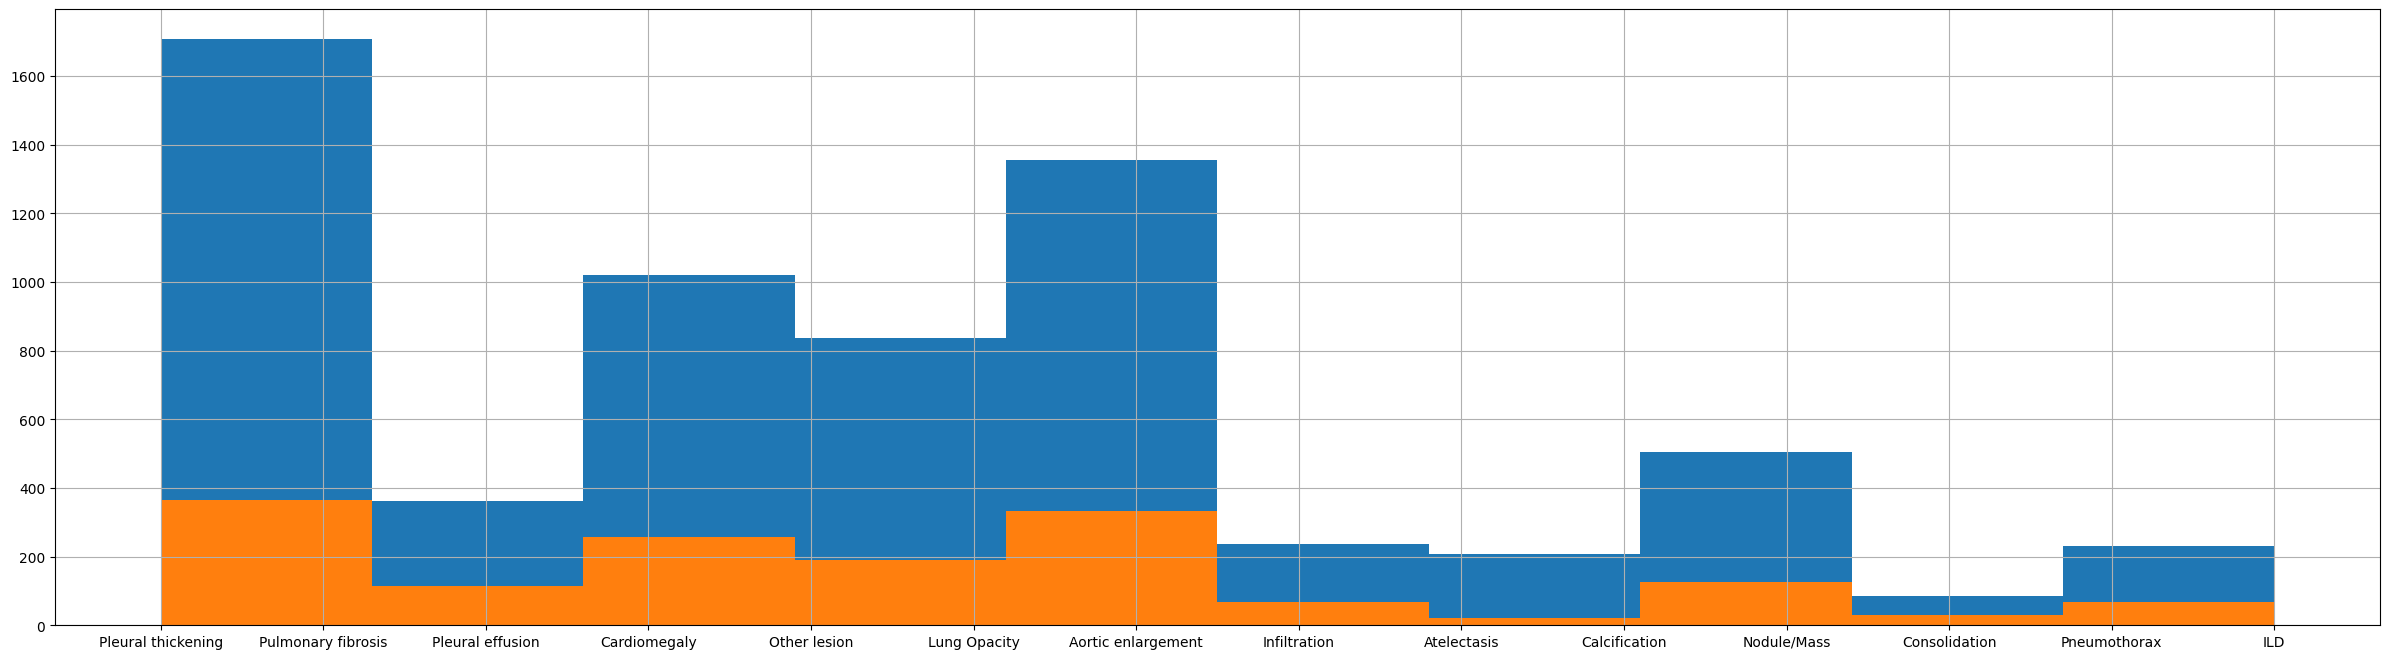

In [9]:
figure(num=None, figsize=(30, 8))
train_df['class_name'].hist()
valid_df['class_name'].hist()
plt.show()

In [10]:
def get_train_transforms():
    return A.Compose(
        [
            A.ToGray(p=0.01), #RGB를 Gray Scale로 변환
            A.HorizontalFlip(p=0.5), 
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),#이미지 크기 변환
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),#64x64크기로 잘라낸다
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc', # object detection의 데이터셋
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [11]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_dir=None, transforms=None):
        super().__init__()

        self.image_ids = marking["image_id"].unique()#train에 사용할 dicom 파일의 이름
        self.marking = marking#train_df
        self.image_dir = image_dir#train에 사용할 dicom파일이 저장된 폴더의 경로
        self.transforms = transforms#get_train_transforms 함수의 return 값

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        records = self.marking[(self.marking['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        #marking(train_df, test_df)에서 일부만 발췌해서 records에 저장
        image, boxes = self.load_image_and_boxes(index)

        labels = records["class_id"].values
        target = {'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels), 'image_id': torch.tensor([index])}

        if self.transforms:
            sample = self.transforms(**{
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            })
            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'][:, [0, 1, 2, 3]] = target['boxes'][:, [1, 0, 3, 2]]
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        image = dicom.pixel_array
        #Photometric interpretation = dicom 이미지의 visualization 관련 정보
        #MONOCHROME1 = pixel이 하얀색으로 나타나는 gray scale image
        #MONOCHROME2 = pixel이 검은색으로 나타나는 gray scale image
        #RGB = 컬러 이미지
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image

        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image.transpose(1, 2, 0)

        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values

        return image, boxes #이미지를 array형태로 box의 두 x좌표와 y좌표를 반환한다

In [12]:
image_paths = DIR+'/train'
train_dataset = DatasetRetriever(
    marking=train_df,
    image_dir=image_paths,
    transforms=get_train_transforms(),
)

validation_dataset = DatasetRetriever(
    marking=valid_df,
    image_dir=image_paths,
    transforms=get_valid_transforms(),
)

In [13]:
image_paths = DIR+'/train'
image_id = train_df["image_id"].unique()[0].split('.')[0]
dicom = pydicom.dcmread(f"{image_paths}/{image_id}.dicom")
image = dicom.pixel_array
image = np.stack([image, image, image])
image = image.astype('float32')
image = image - image.min()
image = image / image.max()
image[1]

array([[0.93846154, 0.93821734, 0.93577534, ..., 0.9023199 , 0.8864469 ,
        0.8908425 ],
       [0.94065934, 0.93699634, 0.93431014, ..., 0.9035409 , 0.8913309 ,
        0.8932845 ],
       [0.93992674, 0.93943834, 0.93626374, ..., 0.9101343 , 0.9028083 ,
        0.8979243 ],
       ...,
       [0.9709402 , 0.970696  , 0.9692308 , ..., 0.9721612 , 0.9714286 ,
        0.973138  ],
       [0.9711844 , 0.970696  , 0.9699634 , ..., 0.970696  , 0.9721612 ,
        0.9772894 ],
       [0.9711844 , 0.9724054 , 0.9711844 , ..., 0.970696  , 0.970696  ,
        0.9746032 ]], dtype=float32)

In [14]:
for i in train_dataset:
  print(i)
  break

(tensor([[[0.0273, 0.0264, 0.0239,  ..., 0.0295, 0.0284, 0.0307],
         [0.0245, 0.0251, 0.0251,  ..., 0.0313, 0.0313, 0.0294],
         [0.0276, 0.0231, 0.0268,  ..., 0.0320, 0.0290, 0.0283],
         ...,
         [0.0726, 0.0674, 0.0726,  ..., 0.0487, 0.0485, 0.0528],
         [0.0792, 0.0790, 0.0843,  ..., 0.0539, 0.0534, 0.0570],
         [0.0913, 0.0897, 0.0983,  ..., 0.0602, 0.0585, 0.0627]],

        [[0.0273, 0.0264, 0.0239,  ..., 0.0295, 0.0284, 0.0307],
         [0.0245, 0.0251, 0.0251,  ..., 0.0313, 0.0313, 0.0294],
         [0.0276, 0.0231, 0.0268,  ..., 0.0320, 0.0290, 0.0283],
         ...,
         [0.0726, 0.0674, 0.0726,  ..., 0.0487, 0.0485, 0.0528],
         [0.0792, 0.0790, 0.0843,  ..., 0.0539, 0.0534, 0.0570],
         [0.0913, 0.0897, 0.0983,  ..., 0.0602, 0.0585, 0.0627]],

        [[0.0273, 0.0264, 0.0239,  ..., 0.0295, 0.0284, 0.0307],
         [0.0245, 0.0251, 0.0251,  ..., 0.0313, 0.0313, 0.0294],
         [0.0276, 0.0231, 0.0268,  ..., 0.0320, 0.0290, 0

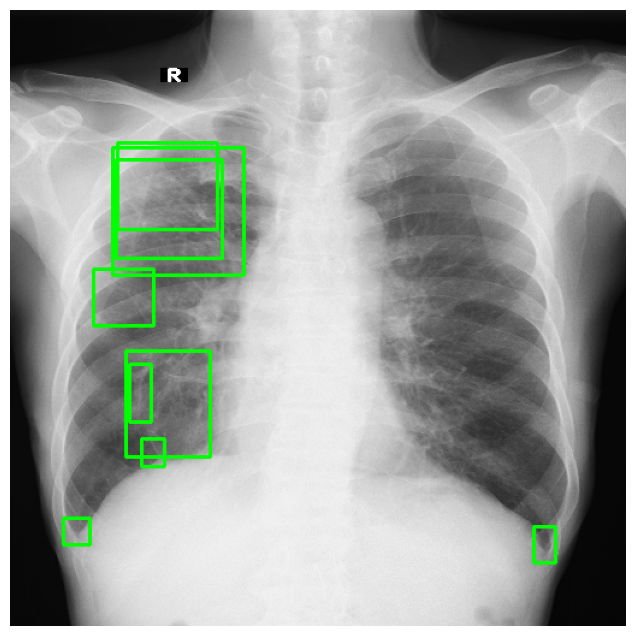

In [15]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int64)

numpy_image = image.permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3], box[2]), (0, 1, 0), 2)

ax.set_axis_off()
ax.imshow(numpy_image)
plt.show()

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
#학습을 위한 코드
class Fitter:
  # config = 학습에 필요한 정보(batch_size, epoch 수, learning rate, verbose(학습 상황을 표시할지 말지(1이면 하고 0이면 안함)), optimizer)

    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}' #해당 코드에서는 logging_path
        if not os.path.exists(self.base_dir):#/content/logging_path 폴더를 생성 해당 폴더에 weights를 저장한다
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        # 모델을 이루는 파라미터 접근 방법:
        #   parameter() = layer 이름을 제외한 parameter 값 출력
        #   named_parameters() = (layer 이름, parameter 값)조합을 tuple 형태로 출력
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        # reproducing the behavior of the original optimizer = optimizer의 행동을 재현
        # 사용 이유: 연산 속도 향상(추정)
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        #AdamW를 optimizer로 사용
        # AdamW와 Adam의 차이
        # AdamW = weight decay 위한 텀 수식이 추가된 Adam
        # weight decay: 
        #   loss function을 줄여 overfitting 문제를 막기 위한 방법
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                #최고 weight 마지막 weight를 저장
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            self.optimizer.zero_grad()
            loss, _, _ = self.model(images, boxes, labels)

            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [18]:
class TrainGlobalConfig:
    num_workers = 1
    batch_size = 4
    folder = 'logging_path'
    n_epochs = 1
    lr = 0.0002
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    #val_loss가 향상되지 않을 때, learning rate를 factor(현 모델에선 0.5)배로 감소시킨다
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [20]:
def run_training():
    net.to(device)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [21]:
def get_net():
  #effidet.config에서 import해온 함수
  # omegaconfig = 프로그램 설정 정보를 가져오는 모듈
  # efficeientdet_d4의 기본 설정 정보를 가져온다
  # bakcbone = 구조 = tf_efficientdet_d4
    config = get_efficientdet_config(model_name='tf_efficientdet_d4')
    # efficientdet_d4의 train bench 구축
    net = EfficientDet(config, pretrained_backbone=False)

    checkpoint = torch.load('/home/ubuntu/ED_project/efficientdet_d4-5b370b7a.pth')
    #모델 불러오기 
    net.load_state_dict(checkpoint)
    config.num_classes = 14
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

In [22]:
net = get_net()

run_training()

TypeError: 'FeatureInfo' object is not callable

In [ ]:
net = get_net()
run_training()

Fitter prepared. Device is cuda

2022-10-04T08:31:05.295920
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 462.47124, time: 798.40221
[RESULT]: Val. Epoch: 0, summary_loss: 582.24465, time: 194.04897
